In [1]:
import pandas as pd
import pyodbc

In [2]:
# Connect to DataBank
connection_string = (
    "DSN=DataBank;"
    "Trusted_Connection=yes;"
)

con = pyodbc.connect(connection_string)

In [3]:
# Write sql query
qry = "SELECT * FROM ukri_ssd_snapshot.2024_10_04_ssd_award_profiles;"

# Read sql query
df= pd.read_sql(qry, con)

C:\Users\MHil02\AppData\Local\Temp\ipykernel_27056\2744576192.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df= pd.read_sql(qry, con)


In [4]:
df['award_reference'].isna().sum()

0

In [5]:
# Write sql query
qry = "SELECT * FROM ukri_ssd_snapshot.2024_10_04_ssd_application;"

# Read sql query
df_applications = pd.read_sql(qry, con)

C:\Users\MHil02\AppData\Local\Temp\ipykernel_27056\746504601.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_applications = pd.read_sql(qry, con)


In [6]:
df_applications[['application_reference', 'award_reference', 'application_source']].duplicated().sum()

291

In [7]:
df_applications.columns

Index(['application_reference', 'award_reference', 'funder', 'decision_owner',
       'application_source', 'administrator', 'opportunity_id',
       'opportunity_name', 'application_category', 'application_status',
       'derived_status', 'decision_date', 'lead_organisation_id',
       'lead_organisation_department_id', 'application_title',
       'amount_applied_for', 'full_economic_cost', 'scheme',
       'rejection_reason', 'date_last_received', 'publish_to_gtr',
       'application_stage', 'application_stage_status', 'joint_proposal',
       'parent_award', 'parent_award_reference', 'redact_abstract_on_gtr',
       'organisation_source', 'international_programme'],
      dtype='object')

In [8]:
df_app = df_applications[['application_reference', 'award_reference', 'application_source', 'funder', 'application_category']].drop_duplicates(keep=False)


In [9]:
data_merge = pd.merge(df, df_app, on=['award_reference', 'application_source'], how='left', indicator=True)


In [10]:
data_merge['amount'].sum()

77266092921.94936

In [11]:
data_merge[data_merge['_merge'] == 'left_only']['amount'].sum()

525199279.9159

In [12]:
525199279.9159/77266092921.94936*100  # < 1% so can exclude

0.6797280152969972

In [13]:
data_both = data_merge.copy()[data_merge['_merge'] == 'both']


In [14]:
data_both['application_category'].unique()

array(['Fellowship', 'Research Grant', 'Training Grant', 'Intramural',
       'P&Cs', 'Research and Innovation', 'Other Grant', 'Studentship',
       None, 'Feasibility Studies', 'Collaborative R&D',
       'GRD Development of Prototype', 'GRD Proof of Market', 'Vouchers',
       'GRD Proof of Concept', 'Small Business Research Initiative',
       'Knowledge Transfer Partnership', 'EU-Funded',
       'BEIS-Funded Programmes', 'Fast Track', 'Legacy RDA Grant for R&D',
       'Study', 'Procurement', 'Grant for R&D', 'Demonstrator',
       'CR&D Bilateral', 'SME Support', 'Large Project',
       'Knowledge Transfer Network', 'Launchpad', 'Centres',
       'Innovation Loans', 'Responsive Strategy and Planning',
       'Special Interest Group', 'Legacy RDA Collaborative R&D',
       'European Enterprise Network',
       'Legacy Department of Trade & Industry', 'Missions',
       'Investment Accelerator', 'Business Connect',
       'Department for Science, Innovation & Technology',
       'M

In [15]:
data_both.drop(columns=['transfer_reference', 'payment_profile_quarter_id', '_merge', 'application_reference_y'], inplace=True)

In [16]:
data_both.rename(columns={'application_reference_x':'application_reference'}, inplace=True)

In [17]:
# Write sql query
qry = "SELECT * FROM ukri_ssd_snapshot.2024_10_04_ssd_award;"

# Read sql query
df_awards = pd.read_sql(qry, con)

C:\Users\MHil02\AppData\Local\Temp\ipykernel_27056\2747524204.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_awards = pd.read_sql(qry, con)


In [18]:
df_awards[['award_reference', 'application_source']].duplicated().sum()

261

In [19]:
df_awards['award_reference'] = df_awards['award_reference'].replace('Unknown', None)

print(df_awards['award_reference'].isna().sum()/len(df_awards)*100)

# Only represents 0.13% of awards

print(df_awards[df_awards['award_reference'].isna()]['funded_amount'].sum()/df_awards['funded_amount'].sum()*100)

# or 0.15% of total funded amount so we can neglect
df_dropna = df_awards[~df_awards['award_reference'].isna()]

0.1261505844657307
0.1517036963978507


In [20]:
# award_reference is not Null and is duplicated
df_dropna[df_dropna['award_reference'].duplicated(keep=False)].sort_values(by='award_reference')['funded_amount'].sum()/df_awards['funded_amount'].sum()*100

0.3187965192515037

In [21]:
# Those duplicated represent 0.32% of total funded amount so we neglect

df_dropna.drop_duplicates(subset='award_reference', keep=False, inplace=True)

C:\Users\MHil02\AppData\Local\Temp\ipykernel_27056\1863951632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna.drop_duplicates(subset='award_reference', keep=False, inplace=True)


In [22]:
df_dropna[df_dropna['start_date'].isna() & df_dropna['end_date'].isna()]['funded_amount'].sum() / df_awards['funded_amount'].sum()*100
# Awards where there are no start or end date (so we cannot tell if they are active or not) represent 1.35% of the total funded value

1.3501916844453263

In [23]:
df_dropna = df_dropna[~(df_dropna['start_date'].isna() & df_dropna['end_date'].isna())]
df_dropna = df_dropna[~df_dropna['end_date'].isna()]
df_dropna = df_dropna[df_dropna['start_date'] < df_dropna['end_date']]

df_dropna['funded_amount'].sum() / df_awards['funded_amount'].sum()*100
# in total we are looking at 98% of the funded amount

98.15924984814613

In [24]:
df_dropna.drop(columns=['project_cost', 'profiled_amount', 'announced_start_date'], inplace=True)

In [25]:
df_dropna[['award_reference', 'application_reference']].duplicated().sum()

0

In [26]:
data_merge = pd.merge(data_both, df_dropna, on=['award_reference', 'application_source'])

In [27]:
print(len(data_merge))
print(len(data_both))

6850332
6853335


In [28]:
data_merge.drop(columns=['application_reference_x', 'termination_date', 'funder_y', 'application_reference_y', 'administrator', 'end_date', 'funded_amount'], inplace=True)

In [29]:
data_merge['payment_status'].unique()

array(['Paid', 'Cancelled', 'Pending', 'Due', 'Held', None], dtype=object)

In [30]:
data_drop = data_merge[data_merge['payment_status'].isin(['Paid', 'Pending', 'Due', 'Held'])]
# payment status is Paid, Pending, Due or Held

In [31]:
data_drop['funding_stream'].unique()
# Tbc whether to filter to Main or not?

data_drop = data_drop.loc[data_drop['funding_stream'] == 'Main']

In [32]:
data_drop.dtypes

award_reference                           object
payment_profile_financial_year             int64
expenditure_type                          object
amount                                   float64
payment_status                            object
funding_stream                            object
payment_type                              object
application_source                        object
funder_x                                  object
application_category                      object
start_date                        datetime64[ns]
dtype: object

In [33]:
data_drop['start_year'] = data_drop['start_date'].dt.year


In [34]:
data_drop['award_id'] = data_drop['award_reference'] + data_drop['application_source']

In [35]:
data_drop['application_category'].unique()

array(['Fellowship', 'Research Grant', 'Training Grant', 'Intramural',
       'Research and Innovation'], dtype=object)

In [36]:
data_drop['funder_x'].unique()

array(['NERC', 'AHRC', 'EPSRC', 'BBSRC', 'MRC', 'GCRF', 'STFC', 'ESRC',
       'Newton Fund', 'NC3Rs', 'Unknown', 'Disputed', 'ISCF', 'UUI',
       'SPF', 'FLF', 'FIC', 'Infrastructure Fund', 'ISPF', 'HEG',
       'Open Access Block Grant', 'COVID', 'TMF'], dtype=object)

In [37]:
# Adjust to real prices
data_gdp = pd.read_excel("..//TRAC-data-deep-dive//GDP_Deflators_Budget_March_2024_update.xlsx", header=6)

data_adj = data_gdp[['Financial year',  '2022-23 = 100']].dropna().iloc[:-14] # Deflator per year

data_adj.rename(columns={'2022-23 = 100':'Deflator'}, inplace=True)

# Calendar year
data_adj = data_gdp[['Calendar year',  '2023 = 100']].dropna().iloc[:-5] # Deflator per year

data_adj.rename(columns={'2023 = 100':'Deflator'}, inplace=True)

data_adj['Calendar year'] = data_adj['Calendar year'].astype(int)

In [38]:
data_merge = pd.merge(data_drop, data_adj, left_on='start_year', right_on='Calendar year')

data_merge['adjusted_amount'] = data_merge['amount']/(data_merge['Deflator']/100)

data_group = data_merge.groupby('start_year', as_index=False).agg({'award_id':'nunique', 'amount':'sum', 'adjusted_amount':'sum'})

error = data_merge.groupby('start_year', as_index=False).agg({'adjusted_amount':'std'}).rename(columns={'adjusted_amount':'std'})

data_group = pd.merge(data_group, error, on='start_year')


In [39]:
data_group['cost_per_grant'] = data_group['amount']/data_group['award_id']
data_group['adj_cost_per_grant'] = data_group['adjusted_amount']/data_group['award_id']

data_plot = data_group.copy()

In [40]:
data_plot = data_plot[data_plot['start_year'] > 2009]

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
# Create an array with the colors you want to use
colors = ["#2E2D62", "#FF6900", "#00A788", "#1E5DF8", "#E355EC", "#3E863E", "#BE2BBB", "#008AAD", "#005E54", "#C13D33"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

sns.color_palette()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

style_dict = {'axes.facecolor': 'white',
              'axes.edgecolor': '.15',
 'axes.grid': True,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': '.8',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': True,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': False,
 'axes.spines.bottom': True,
 'axes.spines.right': False,
 'axes.spines.top': False}

sns.set_style("whitegrid", style_dict)

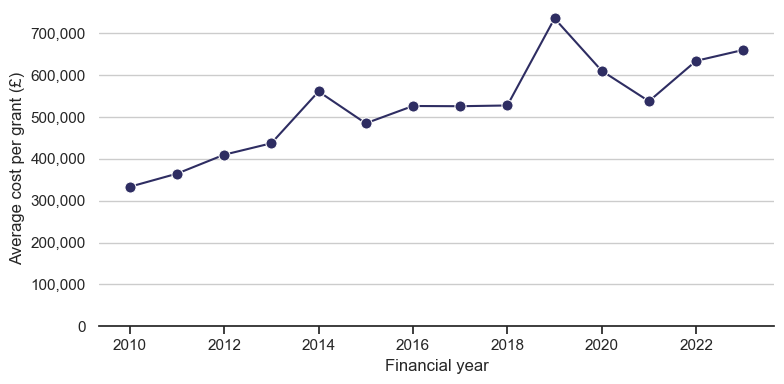

In [42]:
plt.figure(figsize=(8,4))

sns.lineplot(data=data_plot, x='start_year', y='cost_per_grant', marker='o', markersize=8, ax=plt.gca())

plt.grid(axis='x')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.ylabel('Average cost per grant (£)')
plt.xlabel('Financial year')

plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

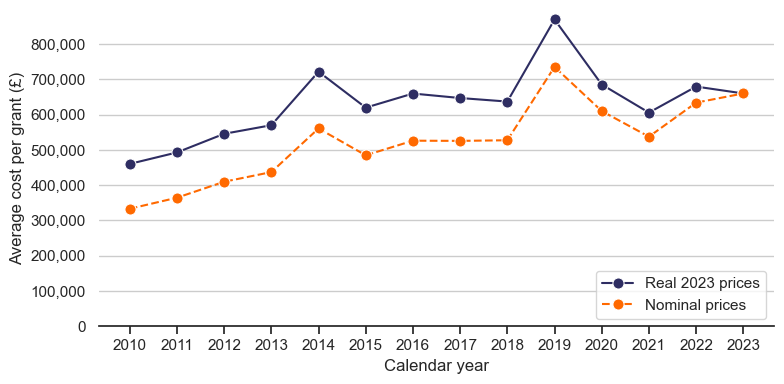

In [43]:
plt.figure(figsize=(8,4))

sns.lineplot(data=data_plot, x='start_year', y='adj_cost_per_grant', marker='o', markersize=8, ax=plt.gca(), label='Real 2023 prices')
sns.lineplot(data=data_plot, x='start_year', y='cost_per_grant', marker='o', markersize=8, ax=plt.gca(), linestyle='--', label='Nominal prices')

plt.ylim(bottom=0)
plt.grid(axis='x')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.ylabel('Average cost per grant (£)')
plt.xlabel('Calendar year')
plt.xticks(data_plot['start_year'])
plt.legend(loc = 'lower right')

plt.tight_layout()
plt.show()

In [44]:
from sklearn.linear_model import LinearRegression


In [45]:
model = LinearRegression()

In [46]:
model.fit(data_plot[['start_year']], data_plot[['adj_cost_per_grant']])

LinearRegression()

In [47]:
model = LinearRegression().fit(data_plot[['start_year']], data_plot[['adj_cost_per_grant']], sample_weight=1/data_plot['std'])

In [48]:
r_sq = model.score(data_plot[['start_year']], data_plot[['adj_cost_per_grant']])
print(f"coefficient of determination: {r_sq}")

coefficient of determination: 0.3623381176400744


In [49]:
y_pred = model.predict(data_plot[['start_year']])

In [50]:
data_plot['y_pred'] = y_pred

C:\Users\MHil02\AppData\Local\Temp\ipykernel_27056\1645752606.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(x=data_plot['start_year'], y=data_plot['adj_cost_per_grant'], yerr=data_plot['std'], label='Real 2022 prices', marker='o', capsize=5, fmt='o')


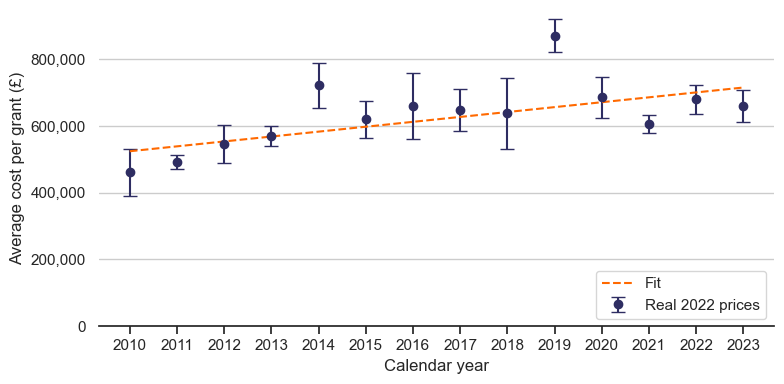

In [51]:
plt.figure(figsize=(8,4))

#sns.lineplot(data=data_plot, x='start_year', y='adj_cost_per_grant', marker='o', markersize=8, ax=plt.gca(), label='Real 2023 prices')

plt.errorbar(x=data_plot['start_year'], y=data_plot['adj_cost_per_grant'], yerr=data_plot['std'], label='Real 2022 prices', marker='o', capsize=5, fmt='o')

sns.lineplot(data=data_plot, x='start_year', y='y_pred', ax=plt.gca(), linestyle='--', label='Fit')


plt.ylim(bottom=0)
plt.grid(axis='x')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.ylabel('Average cost per grant (£)')
plt.xlabel('Calendar year')
plt.xticks(data_plot['start_year'])
plt.legend(loc = 'lower right')

plt.tight_layout()
plt.show()

In [52]:
# model.fit(x_data, y_data, sample_weight=1/y_err)

In [53]:
((data_plot['adj_cost_per_grant'] - data_plot['y_pred'])*(data_plot['adj_cost_per_grant'] - data_plot['y_pred'])/data_plot['y_pred'])

26     7706.917659
27     3883.083179
28      103.720224
29        7.987322
30    33303.959384
31      853.268485
32     3749.071641
33      671.533442
34       27.683978
35    69778.828084
36      327.609542
37     9233.310458
38      596.368296
39     4168.922855
dtype: object

In [54]:
import scipy.stats as stats
import numpy as np

In [55]:
# Calculate the residuals
residuals = data_plot[['adj_cost_per_grant']] - y_pred

# Compute the residual sum of squares (RSS)
rss = np.sum(residuals**2)

print(f"Residual Sum of Squares (RSS): {rss}")

Residual Sum of Squares (RSS): adj_cost_per_grant    84581577993.495697
dtype: object


c:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [56]:
mydict = {
    "DA - Estate Costs":"Estates Costs",
    "DI - Staff":"Staff Costs",
    "Exception - Staff":"Staff Costs",
    "Total - Staff":"Staff Costs",
    "DI - Equipment":"Equipment Costs", 
    "Exception - Equipment":"Equipment Costs",
    "Total - Consumables":"Equipment Costs",
    "Total - Equipment":"Equipment Costs",

    "DA - Investigators":"Investigators Costs", 
    "DI - T&S":"T&S Costs",
    "Exception - T&S":"T&S Costs",
    "Total - T&S":"T&S Costs", 

    "DA - Other Directly Allocated":"Other Costs",
    "DI - Other Costs":"Other Costs", 
    "Total - Other Costs":"Other Costs", 
    "Exception - Other Costs":"Other Costs",

    "Total - Fieldwork":"Direct expenses",
    "Total - Fees":"Direct expenses",

    "Indirect - Indirect Costs":"Indirect Costs",
    "Total - Indirect Costs":"Indirect Costs",

    "Total - RTSG (Research Training Support Grant)":"Training Costs",
    "Total - RTSG":"Training Costs",
    "Total - Robert Skills":"Training Costs",
    "Total - Student Stipend":"Training Costs",
    "Total - DSA (Disabled Students Allowance)":"Training Costs",
    "Total - DSA":"Training Costs"
}

In [57]:
data_merge['expenditure_type'].unique()

array(['Total - Other Costs', 'Total - Staff', 'Total - T&S',
       'Total - Equipment', 'Total - Indirect Costs', 'DA - Estate Costs',
       'DA - Investigators', 'DI - Other Costs', 'DI - Staff', 'DI - T&S',
       'Indirect - Indirect Costs', 'DI - Equipment',
       'DA - Other Directly Allocated', 'Total - Consumables',
       'Exception - Other Costs', 'Exception - Staff',
       'Exception - Equipment', 'Total - Fees', 'Total - RTSG',
       'Total - Student Stipend', 'Exception - T&S', 'Total - Fieldwork',
       'Total - Absence', 'Total - DSA', 'Total - Large Capital',
       'DI - Absence', 'Total - Robert Skills'], dtype=object)

In [62]:
data_2009 = data_merge[data_merge['start_year'] > 2009]


In [63]:
data_2009['expenditure_mapped'] = data_2009['expenditure_type'].apply(lambda x: mydict[x])

C:\Users\MHil02\AppData\Local\Temp\ipykernel_27056\1179155736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2009['expenditure_mapped'] = data_2009['expenditure_type'].apply(lambda x: mydict[x])


In [64]:
data_category = data_2009.groupby(['start_year', 'expenditure_mapped'], as_index=False).agg({'adjusted_amount':'sum', 'award_id':'nunique'})
data_category['adj_cost_per_grant'] = data_category['adjusted_amount']/data_category['award_id']

<Axes: xlabel='start_year', ylabel='adj_cost_per_grant'>

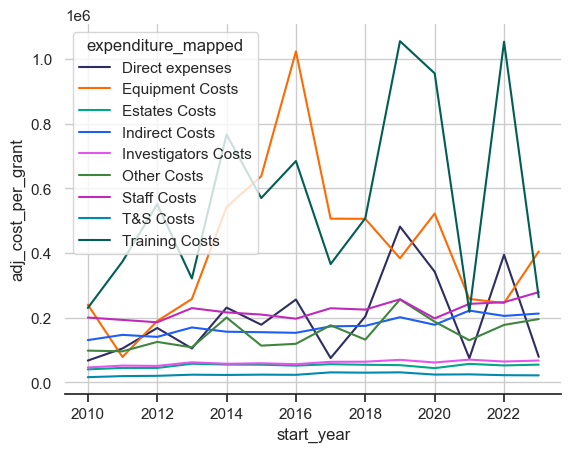

In [66]:

sns.lineplot(data=data_category, x='start_year', y='adj_cost_per_grant', hue='expenditure_mapped')